In [1]:
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import statsmodels
from statsmodels.stats.weightstats import *

In [4]:
from statsmodels.sandbox.stats.multicomp import multipletests 

Необходимо проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

In [5]:
data = pd.read_csv('../data/ab_browser_test.csv')
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


Описание данных:

* userID: уникальный идентификатор пользователя

* browser: браузер, который использовал userID

* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)

* n_clicks: количество кликов, которые пользоваль совершил за n_queries

* n_queries: количество запросов, который совершил userID, пользуясь браузером browser 

* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [6]:
e = data[data['slot']=='exp']['n_clicks'].sum()
c = data[data['slot']=='control']['n_clicks'].sum()

In [7]:
round((e-c)/c*100,3)

1.614

### 2


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

In [8]:
exp = data[data['slot']=='exp']['n_clicks'].values
control = data[data['slot']=='control']['n_clicks'].values

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
np.random.seed(0)

exp_median_scores = list(map(np.median, get_bootstrap_samples(exp, 1000)))
control_median_scores = list(map(np.median, get_bootstrap_samples(control, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(control_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [5. 5.]
95% confidence interval for the CLEC median repair time: [4. 4.]


разность медиан по бутстреп выборке

In [12]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores)))

In [13]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [-1. -1.]


In [14]:
np.random.seed(0)

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp, 1000)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control, 1000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_mean_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(control_mean_scores, 0.05))

95% confidence interval for the ILEC median repair time: [11.5086867  11.66089388]
95% confidence interval for the CLEC median repair time: [11.20795095 11.35742732]


разность средних по бутстреп выборке

In [15]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores)))

In [16]:
print("95% confidence interval for the difference between means",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between means [-0.40475697 -0.19172563]


* 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо


* 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо



### 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

***Все ответы ниже неверны***

1) Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

2) Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

3) Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.

4) Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.


### 4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид (X¯−μ)/√(S^2/n), то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* X¯ — среднее значение в выборке — было распределено нормально N(μ,σ^2/n)
* (n/σ^2)*S^2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы **не знаем истинного распределения** генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого:

* Получите из данных n_boot_samples псевдовыборок.

* По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)

* Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

* Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды

In [17]:
np.random.seed(0)

boot = get_bootstrap_samples(control, 500)
control_mean_scores = list(map(np.mean, boot))

In [18]:
control_boot_chi_squared = np.std(boot, axis=1)**2

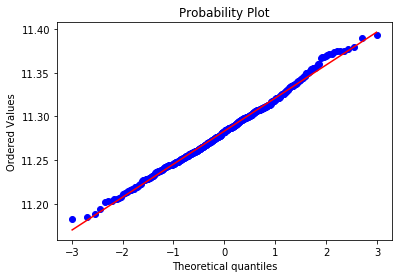

In [19]:
_, osm = scipy.stats.probplot(control_mean_scores, dist="norm",  plot=plt)
pylab.show()

In [20]:
osm

(0.03777466718563097, 11.283244614378994, 0.9979748364604202)

* R^2 для выборочного среднего получился больше, чем 0.99

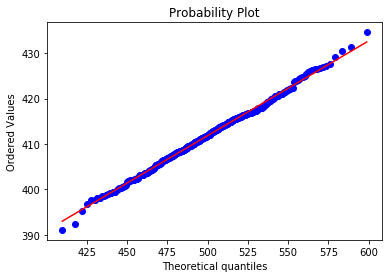

In [21]:
_, osm1 = scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(500-1), plot=plt)

pylab.show()

In [22]:
osm1

(0.2088666287979423, 307.4001265880714, 0.9986416698820312)


* R^2
  для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

### 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? 

In [23]:
data_e = data[data['slot']=='exp']
data_c = data[data['slot']=='control']

In [24]:
unique_e = data_e.groupby('userID')['n_clicks'].sum()
unique_c = data_c.groupby('userID')['n_clicks'].sum()

С помощью критерия Манна-Уитни проверим гипотезы:


* Н0: средние равны

* Н1: средние не равны

In [25]:
stats.mannwhitneyu(unique_e, unique_c)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Получившееся значение достигаемого уровня значимости **свидетельствует о статистической значимости отличий между двумя выборками**

### 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.


В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [26]:
br2e = data[(data['slot']=='exp')&(data['browser']=='Browser #2')]['n_clicks']
br2c = data[(data['slot']=='control')&(data['browser']=='Browser #2')]['n_clicks']

In [27]:
stats.mannwhitneyu(br2e, br2c)

MannwhitneyuResult(statistic=1522572720.0, pvalue=0.0272438604197241)

In [28]:
br4e = data[(data['slot']=='exp')&(data['browser']=='Browser #4')]['n_clicks']
br4c = data[(data['slot']=='control')&(data['browser']=='Browser #4')]['n_clicks']

In [29]:
stats.mannwhitneyu(br4e, br4c)

MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984)

In [30]:
br14e = data[(data['slot']=='exp')&(data['browser']=='Browser #14')]['n_clicks']
br14c = data[(data['slot']=='control')&(data['browser']=='Browser #14')]['n_clicks']

In [31]:
stats.mannwhitneyu(br14e, br14c)

MannwhitneyuResult(statistic=806984730.5, pvalue=0.0)

In [32]:
br17e = data[(data['slot']=='exp')&(data['browser']=='Browser #17')]['n_clicks']
br17c = data[(data['slot']=='control')&(data['browser']=='Browser #17')]['n_clicks']

In [33]:
stats.mannwhitneyu(br17e, br17c)

MannwhitneyuResult(statistic=131389681.0, pvalue=0.03740060143010802)

In [34]:
br20e = data[(data['slot']=='exp')&(data['browser']=='Browser #20')]['n_clicks']
br20c = data[(data['slot']=='control')&(data['browser']=='Browser #20')]['n_clicks']

In [35]:
stats.mannwhitneyu(br20e, br20c)

MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377)

In [36]:
br22e = data[(data['slot']=='exp')&(data['browser']=='Browser #22')]['n_clicks']
br22c = data[(data['slot']=='control')&(data['browser']=='Browser #22')]['n_clicks']

In [37]:
stats.mannwhitneyu(br22e, br22c)

MannwhitneyuResult(statistic=2547597959.5, pvalue=0.2574055152210032)

In [38]:
p_value =[0.0272438604197241, 0.40760617658454984, 0.0,
 0.03740060143010802, 0.45366656388735377,0.2574055152210032 ]

In [39]:
reject, p_corrected, a1, a2 = multipletests(p_value, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh') 
reject

array([False, False,  True, False, False, False])

Kоличество незначимых изменений с точки зрения результатов, полученных после введения коррекции: **5**

### 7

Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

1

In [40]:
data[(data['slot']=='exp')&(data['browser']=='Browser #2')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #2')]['n_queries'].sum()*100

44.982746948554706

In [41]:
data[(data['slot']=='control')&(data['browser']=='Browser #2')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #2')]['n_queries'].sum()*100

45.96274717919465

2

In [42]:
data[(data['slot']=='exp')&(data['browser']=='Browser #4')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #4')]['n_queries'].sum()*100

45.14294190358467

In [43]:
data[(data['slot']=='control')&(data['browser']=='Browser #4')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #4')]['n_queries'].sum()*100

46.97092963514274

3

In [44]:
data[(data['slot']=='exp')&(data['browser']=='Browser #14')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #14')]['n_queries'].sum()*100

43.755617361273295

In [45]:
data[(data['slot']=='control')&(data['browser']=='Browser #14')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #14')]['n_queries'].sum()*100

57.59041136008114

4

In [46]:
data[(data['slot']=='exp')&(data['browser']=='Browser #17')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #17')]['n_queries'].sum()*100

36.93741284866483

In [47]:
data[(data['slot']=='control')&(data['browser']=='Browser #17')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #17')]['n_queries'].sum()*100

36.29936674628208

5

In [48]:
data[(data['slot']=='exp')&(data['browser']=='Browser #20')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #20')]['n_queries'].sum()*100

38.97737648371716

In [49]:
data[(data['slot']=='control')&(data['browser']=='Browser #20')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #20')]['n_queries'].sum()*100

40.540484743383296

6

In [50]:
data[(data['slot']=='exp')&(data['browser']=='Browser #22')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='exp')&(data['browser']=='Browser #22')]['n_queries'].sum()*100

39.85394721969546

In [51]:
data[(data['slot']=='control')&(data['browser']=='Browser #22')]['n_nonclk_queries'].sum()/ \
            data[(data['slot']=='control')&(data['browser']=='Browser #22')]['n_queries'].sum()*100

40.593976593513354


С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.

